In [18]:
import warnings; warnings.simplefilter('ignore')

# Detecting Forest Change using Landsat 8 imagery  

In this notebook forest change is detected by observing two contiguous acquisitions from `landsat_8` imagery. The comparisons between a `before` and `after` images offers insight into changes in vegetation and inundation over a varied topography to give indication of deforestation. A broader history spanning one year into the past is also considered 
  
The diagram below shows a series of very simple rules applied to a given point in the imagery to make a classification of `forest changed` or `not changed`

![](diagrams/forest_change/random_forest_tree.PNG)

## Rule 1:  vegetation decreases significantly   

`NDVI` is an index that correlates highly with the existence of vegetation. Its formulation is simple  
  
$$pixel_{NDVI} = \frac{pixel_{NIR} - pixel_{red}}{pixel_{NIR} + pixel_{red}} $$

Implementation, with the help of `xarray` datastructures is equally as simple.  

In [19]:
def ndvi(dataset):  
    return ((dataset.nir - dataset.red)/(dataset.nir + dataset.red)).rename("NDVI")

In this step. The comparison of `before` and `after` NDVI values can indicate a loss of vegetation and is used as the first criteria for detecting deforestation.  
  
The comparison relies on differencing between acquisitions.  

In [20]:
def delta(before, after):
    return after - before

def vegetation_change(before, after):
    vegetation_before = ndvi(before)
    vegetation_after  = ndvi(after)
    
    return delta(vegetation_before,
                 vegetation_after)


Through a process of visual survey a threshold is determined for NDVI decrease.  In our example the determined threshold is `0.18`, which means that pixels with NDVI subtraction smaller than -0.18 will be retained, larger than (-0.18) will not be considered as a possible point of deforestation

In [21]:
def meets_devegetation_criteria(before,after, threshold = -0.18):
    #In this code the following comparison is applied to all pixels.
    #It returns a grid of True and False values to be used for filtering our dataset.  
    return (vegetation_change(before, after) < threshold).rename("devegetation_mask").astype(bool)

<br>  

## Rule 2: vegetation decrease is not the result of agricultural activity
Agricultural cultivation often occurs on flat and low land. This assumption is used to deal with the possibility of agricultural activity interfereing with a detection of deforestation/devegatation.  
  
Thus, pixels with DEM value smaller than 30m are discarded. 

In [22]:
## ASTER

def meets_minimum_height_criteria(aster_ds, threshold = 30):
    return  (aster_ds.num > threshold).astype(bool).rename("height_mask")

## Rule 3: vegetation decrease is not in an area that is known for inundation

Most forests are tall with canopies obscuring the view of the forest floor. Visually speaking, flooding should have very little effect in NDVI values since flooding happens below the canopy.  
  
The presence of water at some point in the year might indicate that the detected vegetation is not forest, but an agricultural area or pond covered by vegetation water-fern.  

`MNDWI` is a calculated index that correlates highly with the existence of water. Like `NDVI` its formulation is simple.  
<br>    
$$MNDWI = \frac{pixel_{green} - pixel_{swir1}}{pixel_{green} + pixel_{swir1}} $$  
  
So is the implementation in code  


In [23]:
def mndwi(dataset):  
    return (dataset.green - dataset.swir1)/(dataset.green + dataset.swir1).rename("MNDWI")     
#In this code the following arithmetic is applied to all pixels in a dataset  

<br>
In this step, the entire `MNDWI` history(time component) is analyzed and the **max** `MNDWI` is taken into account for each pixel. If, at some point in time, any MNDWI surpases some threshold, the assumption is made that the area is not a forest.    
<br>

In [24]:
def max_mndwi(dataset): 
    #In this code max is applied accross across all pixels along a time component. 
    _max = mndwi(dataset).max(dim = ['time'])
    return _max.rename("max_MNDWI")

A threshold is emperically evaulated to reduce the rate of false positives caused by inundated areas. In this case that threshold is 0. Pixels with max_MNDWI smaller than 0 will be retained, greater be discarded. 

In [25]:
def meets_inundation_criteria(dataset, threshold = 0.0):
    return (max_mndwi(dataset) < threshold).rename("inundation_mask")

## Rule 4: vegetation decrease isn't a recurring or normal phenomena  

In [26]:
def create_ndvi_matrix(ds):
    ndvi_matrix            = ndvi(ds) 
    return ndvi_matrix.where(ds.cloud_mask)

def delta_matrix(ds):
    return np.diff(ds, axis = 0) 

def vegetation_sum_threshold(ds, threshold = 10):
    ndvi_delta_matrix = delta_matrix(create_ndvi_matrix(ds)) # lat,lon,t-1 matrix
    ndvi_change_magnitude = np.absolute(ndvi_delta_matrix)   # lat,lon,t-1 matrix
    cummulative_ndvi_change_magnitude = np.nansum(ndvi_change_magnitude, axis = 0) #lat, lon matrix,
    ndvi_change_repeat_mask = cummulative_ndvi_change_magnitude < threshold        #lat, lon boolean matrix
    return xr.DataArray(ndvi_change_repeat_mask,
                        dims = ["latitude", "longitude"],
                        coords = {"latitude": ds.latitude, "longitude": ds.longitude},
                        attrs = {"threshold": threshold},
                        name = "repeat_devegetation_mask")

## Rule 5: vegetation decrease happens in large areas    

The assumption is made that deforestation happens on a sufficiently large scale. Another assumption is made that detected deforestation in a pixel is typically spatially correlated with deforestation in adjacent pixels.  
  
Following this reasoning, the final filter retains groups of deforestation larger than `5` pixels per group. The diagram below 
illustrates a candidate for deforestation based on this grouping criteria, and one that is rejected based on this criteria.   
  
<br>  

![](https://i.imgur.com/t7HAOQr.png)  
<br>  


The implementation relies on adequately grouping pixels in an efficient manner. The use of `skimage`'s  `measure` module yields segemented arrays of pixel groups.  


<br>
![](http://imgur.com/OMO95gw.png)

<br>

In [27]:
from skimage import measure
import numpy as np

def group_pixels(array, connectivity = 1):
    arr = measure.label(array, connectivity=connectivity)
    return [np.dstack(np.where(arr == y))[0] for y in range(1,np.amax(arr))]

In [28]:
def numpy_group_mask(boolean_np_array, min_size = 5):  
    all_groups = group_pixels(boolean_np_array.astype(int))
    candidate_groups = filter(lambda group:
                                  (len(group) > min_size) & (group != 0).all(),
                                  all_groups)
    candidate_pixels = (pixel for group in candidate_groups for pixel in group)  
    dynamic_array = np.zeros(boolean_np_array.shape) 
    for x,y in candidate_pixels:
        dynamic_array[x][y] = 1  
    return dynamic_array.astype(bool)

<br>

In [29]:
def boolean_xarray_segmentation_filter(da,  min_size = 5):
    mask_np = numpy_group_mask(da.values,min_size = 5)
    return xr.DataArray(mask_np,
                        dims = da.dims,
                        coords = da.coords,
                        attrs = {"group_size": min_size},
                        name = "filtered_chunks_mask")

----   


# Run on a small area 

>### The area
>Our test case operates on a small region of Colombia called Salgar    

In [30]:
latitude  = (5.924342,5.9695)
longitude = (-75.912945,-75.9931)
date_range = ('2000-01-01', '2002-01-01')

> ### A quick visualization  

In [31]:
## The code below renders a map that can be used to orient yourself with the region.
from utils.data_cube_utilities.dc_display_map import display_map
display_map(latitude = latitude, longitude = longitude)

> ### Loading Data for the Area
> The following lines of code load in ASTER DEM data, and Landsat7 data through datacube's python api.  

In [32]:
import datacube
dc = datacube.Datacube(config = '/home/localuser/.datacube.conf')

> ### Define the loads

**Landsat 7**

In [33]:
colombia_ls7_extents = dict(latitude     = latitude,
                            longitude    = longitude,
                            platform     = "LANDSAT_7",
                            product      = "ls7_ledaps_salgar_colombia",
                            time         = date_range,
                            measurements = ['red','green','blue','nir','swir1', 'swir2', 'pixel_qa'] )  

**ASTER GDEM V2**

In [34]:
colombia_aster_extents = dict(latitude = (5.924342,5.9695),
                              longitude = (-75.912945,-75.9931),
                              platform = "TERRA",
                              product = "terra_aster_gdm_salgar_colombia")  

** Load Products ** 

In [35]:
landsat_dataset = dc.load(**colombia_ls7_extents)
aster_dataset   = dc.load(**colombia_aster_extents)

In [91]:
landsat_dataset

<xarray.Dataset>
Dimensions:    (latitude: 167, longitude: 297, time: 27)
Coordinates:
  * time       (time) datetime64[ns] 2000-01-10T15:11:22 2000-05-01T15:10:48 ...
  * latitude   (latitude) float64 5.969 5.969 5.969 5.969 5.968 5.968 5.968 ...
  * longitude  (longitude) float64 -75.99 -75.99 -75.99 -75.99 -75.99 -75.99 ...
Data variables:
    red        (time, latitude, longitude) int16 2296 2013 1746 1784 1937 ...
    green      (time, latitude, longitude) int16 2414 2102 1892 1934 2039 ...
    blue       (time, latitude, longitude) int16 2315 2035 1790 1810 1942 ...
    nir        (time, latitude, longitude) int16 4411 4206 4001 3918 4042 ...
    swir1      (time, latitude, longitude) int16 2817 2591 2441 2466 2566 ...
    swir2      (time, latitude, longitude) int16 1778 1594 1462 1488 1567 ...
    pixel_qa   (time, latitude, longitude) int32 224 224 224 224 224 224 224 ...
Attributes:
    crs:      EPSG:4326

In [92]:
aster_dataset

<xarray.Dataset>
Dimensions:    (latitude: 167, longitude: 297, time: 1)
Coordinates:
  * time       (time) datetime64[ns] 2017-09-01T15:10:53
  * latitude   (latitude) float64 5.969 5.969 5.969 5.969 5.968 5.968 5.968 ...
  * longitude  (longitude) float64 -75.99 -75.99 -75.99 -75.99 -75.99 -75.99 ...
Data variables:
    dem        (time, latitude, longitude) int16 1595 1583 1567 1567 1561 ...
    num        (time, latitude, longitude) int16 5 5 6 6 6 5 5 6 7 7 7 7 8 8 ...
Attributes:
    crs:      EPSG:4326

In [93]:
aster_dataset.latitude.values[0]
landsat_dataset.latitude.values[0]

5.9694907825000003

# Pick a time

In [36]:
from ipywidgets import widgets
from IPython.display import display, HTML
import time  

from ipywidgets import widgets
from IPython.display import display, HTML

def create_acq_date_gui(acq_dates):
    acq_date_sel = widgets.Dropdown(options=acq_dates, values=acq_dates)
    display(widgets.Label('Pick a Date: '), acq_date_sel)
    return acq_date_sel

def reformat_n64(t):
        return time.strftime("%Y-%m-%d", time.gmtime(t.astype(int)/1000000000))  
    
acq_dates = list(map(reformat_n64, landsat_dataset.time.values))
dates_from_widget = create_acq_date_gui(acq_dates)

In [87]:
target_date  = dates_from_widget.value
target_index = acq_dates.index(target_date)

In [88]:
from datetime import datetime , timedelta

year_before_target_date = datetime.strptime(target_date, '%Y-%m-%d') - timedelta(days = 365)
year_of_landsat_dataset = landsat_dataset.sel(time = slice(year_before_target_date, target_date))

In [90]:
year_of_landsat_dataset

<xarray.Dataset>
Dimensions:    (latitude: 167, longitude: 297, time: 17)
Coordinates:
  * time       (time) datetime64[ns] 2000-10-08T15:08:54 2000-11-25T15:08:52 ...
  * latitude   (latitude) float64 5.969 5.969 5.969 5.969 5.968 5.968 5.968 ...
  * longitude  (longitude) float64 -75.99 -75.99 -75.99 -75.99 -75.99 -75.99 ...
Data variables:
    red        (time, latitude, longitude) int16 3520 3536 3452 3418 3502 ...
    green      (time, latitude, longitude) int16 3513 3513 3494 3476 3476 ...
    blue       (time, latitude, longitude) int16 20000 20000 20000 3355 3388 ...
    nir        (time, latitude, longitude) int16 4920 4883 4845 4883 4771 ...
    swir1      (time, latitude, longitude) int16 2324 2347 2302 2302 2279 ...
    swir2      (time, latitude, longitude) int16 1884 1956 1861 1909 1789 ...
    pixel_qa   (time, latitude, longitude) int32 224 224 224 224 224 224 224 ...
Attributes:
    crs:      EPSG:4326

>#### A quick RGB visualization function

In [41]:
%matplotlib inline
import numpy as np  
import matplotlib.pyplot as plt

from utils.data_cube_utilities.dc_displayutil import display_at_time

## Used to plot rgb composites of xarray. Simply pass in a dataset, adjust the 'at_index' parameter 
def rgb(dataset, at_index = 0, bands = ['red', 'green', 'blue'], paint_on_mask = [], figsize = (20,20)):
    
    # Values
    rgb = np.stack([dataset[bands[0]], dataset[bands[1]], dataset[bands[2]]], axis = -1)
    max_possible = 3500
    rgb = rgb.astype(np.float32)
    rgb[rgb<0] = 0
    rgb[rgb > max_possible] = max_possible
    rgb *= 255.0/rgb.max()

    rgb = rgb.astype(int)
    rgb = rgb.astype(np.float32)
    rgb = 255-rgb
    
    rgb[rgb > 254] = 254
    rgb[rgb < 1]   = 1
    
    #Masking 
    for mask, color in paint_on_mask:        
        rgb[mask] = np.array([256,256,256]) - np.array(color).astype(np.int16)
    
    plt.figure(figsize = figsize)
    if 'time' in dataset:
        plt.imshow((rgb[at_index]))
    else:
        plt.imshow(rgb)  

# Generate a boolean mask to filter clouds  
TODO: Change `land_cover_endcoding` to Landsat 8 pixel QA encoding  

In [42]:
from functools import reduce  
import numpy as np  
import xarray as xr

def ls7_qa_mask(dataset, keys):
    land_cover_endcoding = dict( fill     =  [1], 
                                 clear    =  [66,  130], 
                                 water    =  [68,  132],
                                 shadow   =  [72,  136],
                                 snow     =  [80,  112, 144, 176],
                                 cloud    =  [96,  112, 160, 176, 224],
                                 low_conf =  [66,  68,  72,  80,  96,  112],
                                 med_conf =  [130, 132, 136, 144, 160, 176],
                                 high_conf=  [224]
                               ) 
    def merge_lists(a, b): 
        return a.union(set(land_cover_endcoding[b]))
                        
    relevant_encodings = reduce(merge_lists, keys,set())

    return xr.DataArray( np.isin(dataset.pixel_qa,list(relevant_encodings)),
                         coords = dataset.pixel_qa.coords,
                         dims = dataset.pixel_qa.dims,
                         name = "cloud_mask",
                         attrs = dataset.attrs)  

<br>

In [43]:
is_clear_mask = ls7_qa_mask(year_of_landsat_dataset, ['clear', 'water']) 

Display contents 

In [44]:
is_clear_mask

<xarray.DataArray 'cloud_mask' (time: 17, latitude: 167, longitude: 297)>
array([[[False, False, ..., False, False],
        [False, False, ..., False, False],
        ..., 
        [False, False, ..., False, False],
        [False, False, ..., False, False]],

       [[ True,  True, ...,  True,  True],
        [ True,  True, ...,  True,  True],
        ..., 
        [False, False, ...,  True,  True],
        [False, False, ...,  True,  True]],

       ..., 
       [[ True,  True, ...,  True,  True],
        [ True,  True, ...,  True,  True],
        ..., 
        [ True,  True, ..., False, False],
        [ True,  True, ..., False, False]],

       [[ True,  True, ...,  True,  True],
        [ True,  True, ...,  True,  True],
        ..., 
        [ True,  True, ..., False, False],
        [ True,  True, ..., False, False]]], dtype=bool)
Coordinates:
  * time       (time) datetime64[ns] 2000-10-08T15:08:54 2000-11-25T15:08:52 ...
  * latitude   (latitude) float64 5.969 5.969 5.969 5.9

>### Add landsat and cloud mask to a common Xarray

In [45]:
product_dataset =   xr.merge([year_of_landsat_dataset, is_clear_mask])

>### Unfiltered image at selected time 

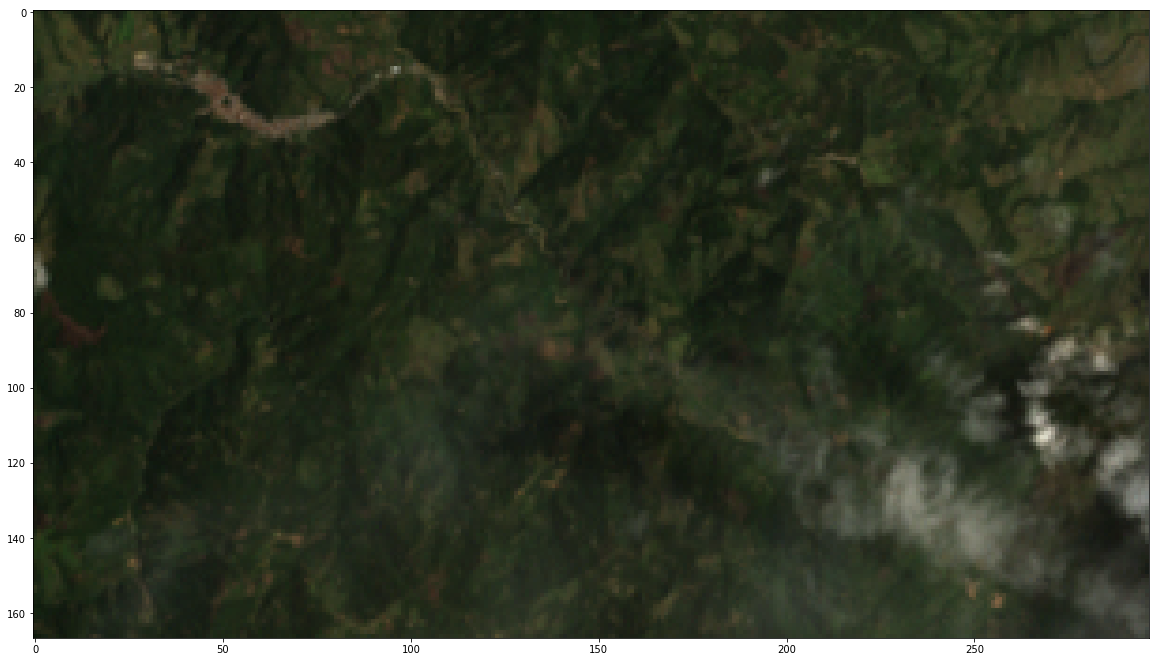

In [46]:
rgb(landsat_dataset, at_index = target_index)

> ### Retained Pixels after filtering (in red) 

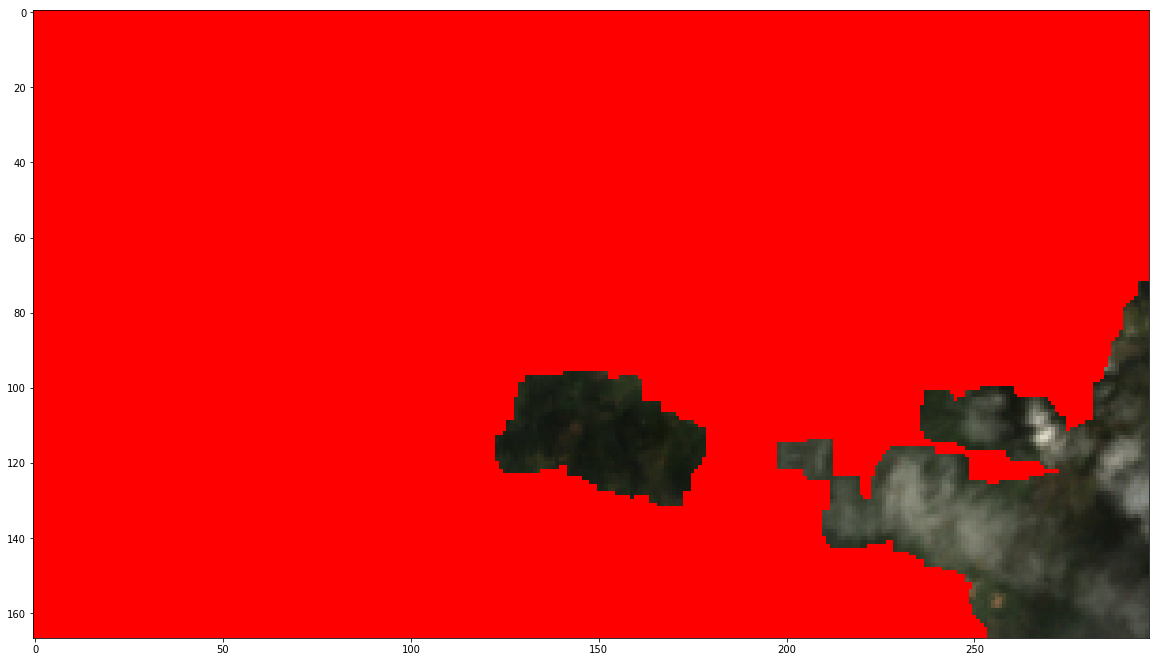

In [47]:
rgb(product_dataset, at_index = -1, paint_on_mask = [((product_dataset.cloud_mask.values), (255,0,0))])

>### Filtered Imagery 

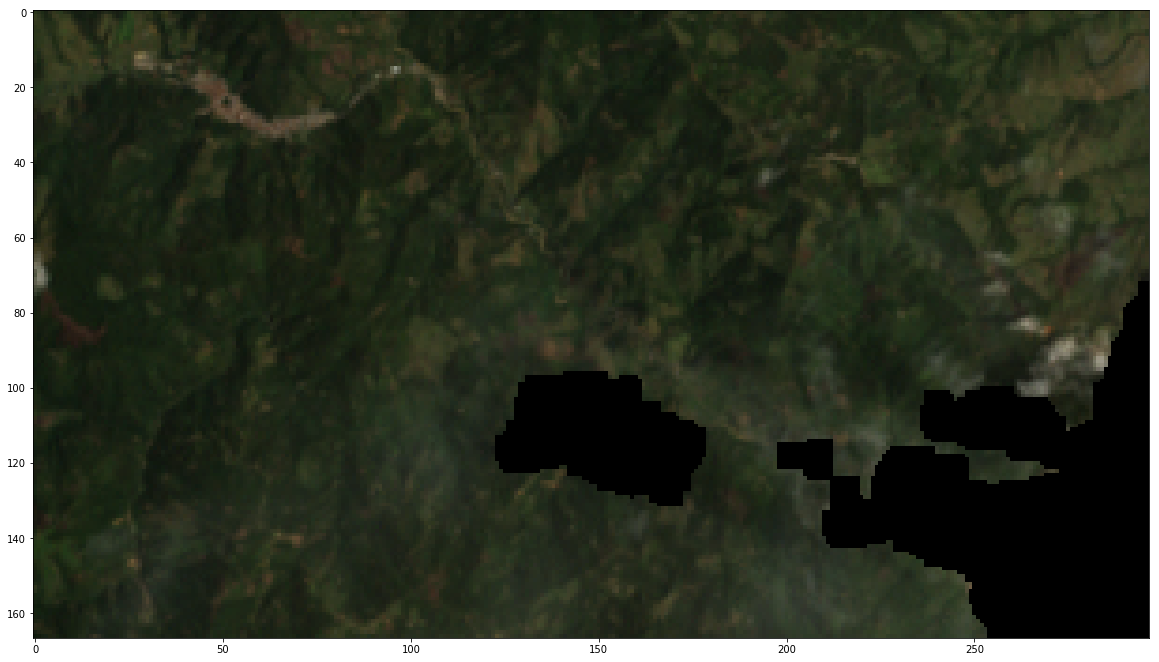

In [49]:
rgb(product_dataset, at_index = -1, paint_on_mask = [(np.invert(product_dataset.cloud_mask.values), (0,0,0))])

# STEP 1: NDVI Decrease

In [50]:
after = product_dataset  .isel(time = -1)
before = product_dataset .isel(time = -2)

In [51]:
devegetation_mask = meets_devegetation_criteria(before,after,threshold = -0.18)

In [52]:
product_dataset = xr.merge([product_dataset, devegetation_mask])

In [53]:
def nan_to_bool(nd_array):
    nd = nd_array.astype(float)
    nd[np.isnan(nd)] = 0
    
    return nd.astype(bool)

> ### NDVI change mask (in red)

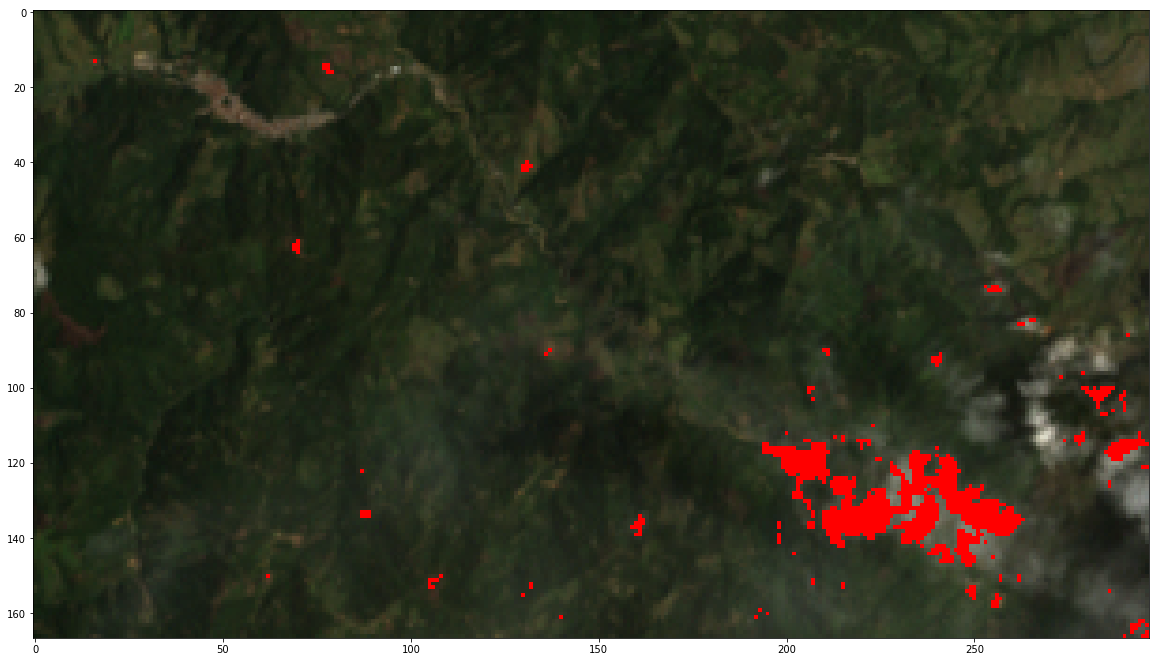

In [54]:
rgb(product_dataset, at_index = -1,
    paint_on_mask = [(nan_to_bool(product_dataset.where(devegetation_mask).red.values), (255,0,0))])

> ### NDVI change + previous mask

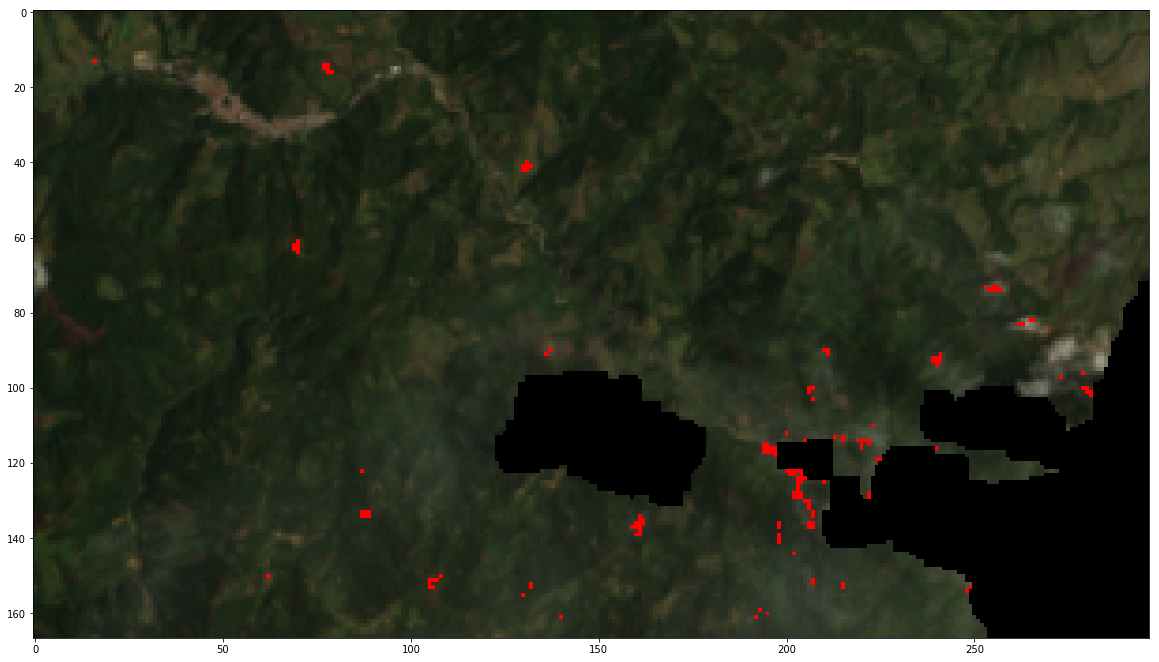

In [55]:
rgb(product_dataset, at_index = -1,
    paint_on_mask = [(nan_to_bool(product_dataset.where(devegetation_mask).red.values), (255,0,0)),
                     (np.invert(nan_to_bool(product_dataset.cloud_mask.values)), (0,0,0))])

> ### Remaining pixels after filtering  

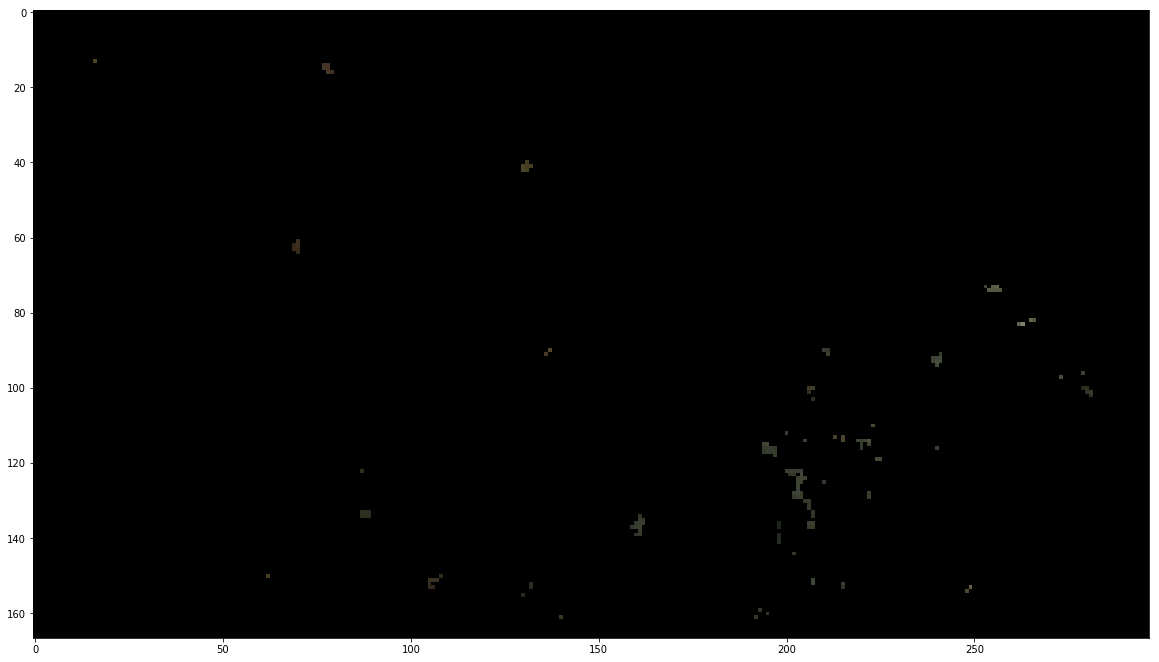

In [56]:
rgb(product_dataset,
    at_index = -1,
    paint_on_mask = [(np.invert(nan_to_bool(product_dataset.where(devegetation_mask).red.values)), (0,0,0)),
                     (np.invert(nan_to_bool(product_dataset.cloud_mask.values)), (0,0,0))])

# Step 2: Filter DEM

Elevation in Salgar Colombia might have a unique distribution of heights. Therefore, It makes sense to look at a histogram of all hieights and determine an appropriate threshold specific to this area.  
<br>

(array([   30.,   621.,   919.,  1958.,  4503.,     0.,  6023.,  8823.,
         8336.,  6043.,     0.,  4785.,  3943.,  2836.,   709.,    70.]),
 array([  1.    ,   1.8125,   2.625 ,   3.4375,   4.25  ,   5.0625,
          5.875 ,   6.6875,   7.5   ,   8.3125,   9.125 ,   9.9375,
         10.75  ,  11.5625,  12.375 ,  13.1875,  14.    ]),
 <a list of 16 Patch objects>)

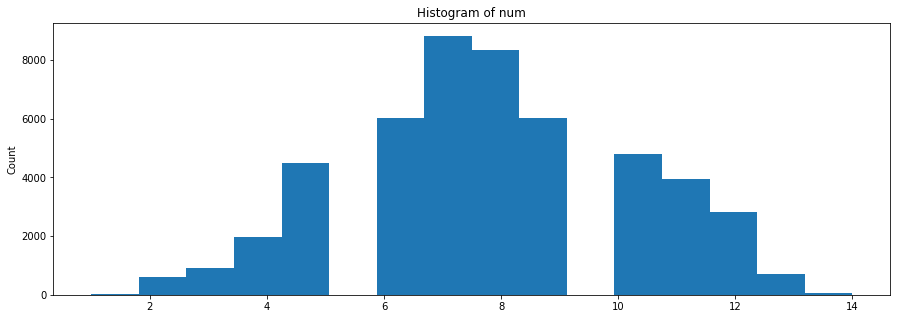

In [57]:
aster_dataset.num.plot.hist(figsize = (15,5), bins = 16)

<br>
The lack of validation data, with regards to height and agriculture means we pick an arbitrary threshold for filtering. The threshold of 5 was chosen.  
<br>

In [58]:
height_mask = meets_minimum_height_criteria(aster_dataset.isel(time = 0), threshold = 5)

In [59]:
product_dataset = xr.merge([product_dataset, height_mask])

>### Valid Height Mask

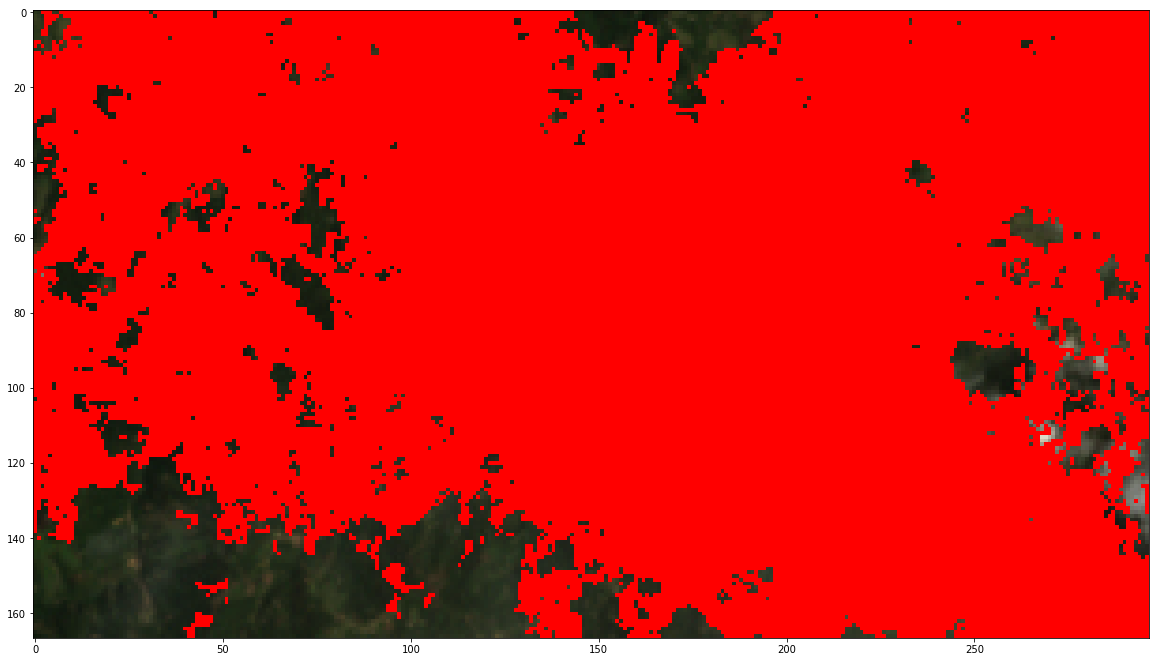

In [60]:
rgb(product_dataset,
    at_index = -1,
    paint_on_mask = [((nan_to_bool(product_dataset.where(height_mask).red.values)), (255,0,0))])

>### Height Mask + Previous Filters

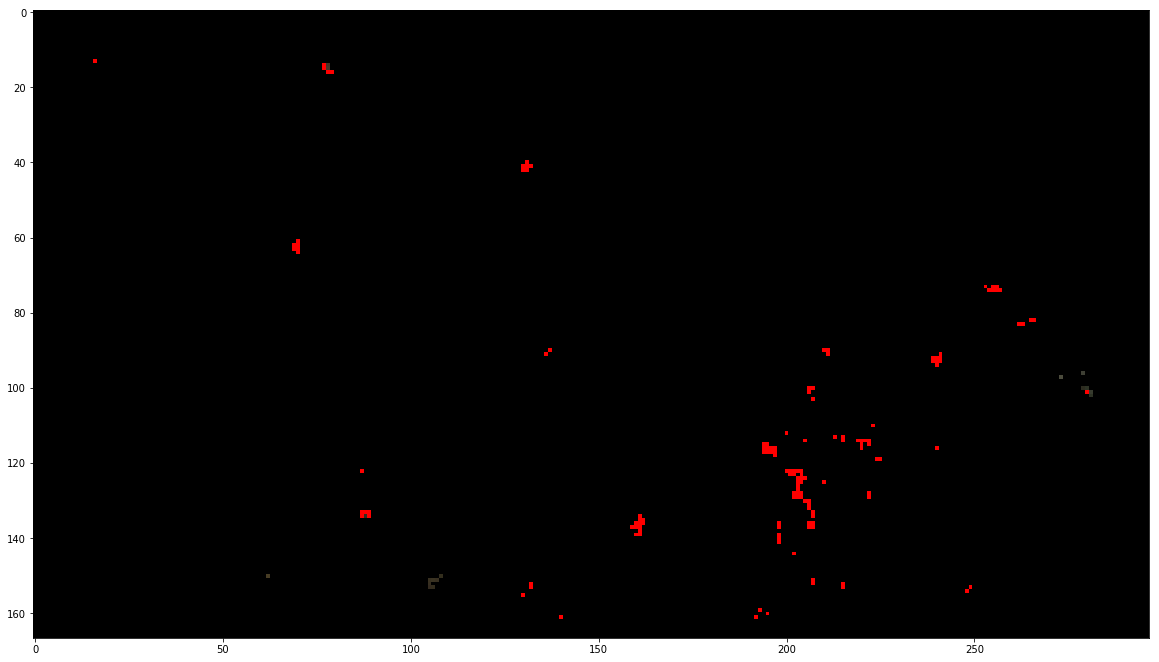

In [61]:
rgb(product_dataset,
    at_index = -1,
    paint_on_mask = [((nan_to_bool(product_dataset.where(height_mask).red.values)), (255,0,0)),
                     (np.invert(nan_to_bool(product_dataset.where(devegetation_mask).red.values)), (0,0,0)),
                     (np.invert(nan_to_bool(product_dataset.cloud_mask.values)), (0,0,0))])

>### Remaining 

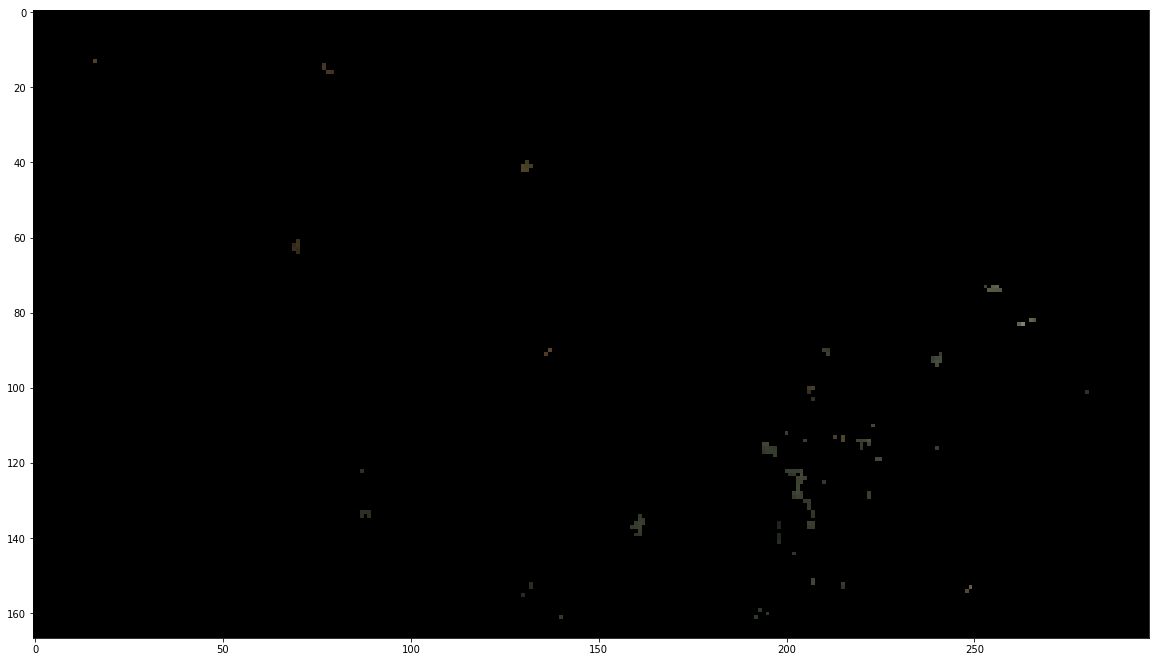

In [62]:
rgb(product_dataset,
    at_index = -1,
    paint_on_mask = [(np.invert(nan_to_bool(product_dataset.where(height_mask).red.values)), (0,0,0)),
                     (np.invert(nan_to_bool(product_dataset.where(devegetation_mask).red.values)), (0,0,0)),
                     (np.invert(nan_to_bool(product_dataset.cloud_mask.values)), (0,0,0))])

# STEP 3: Filter inundation criteria 

In [63]:
cloudless_dataset = product_dataset.where(product_dataset.cloud_mask)
inundation_mask = meets_inundation_criteria(cloudless_dataset)

In [64]:
product_dataset = xr.merge([product_dataset, inundation_mask])

>### Inundation Mask

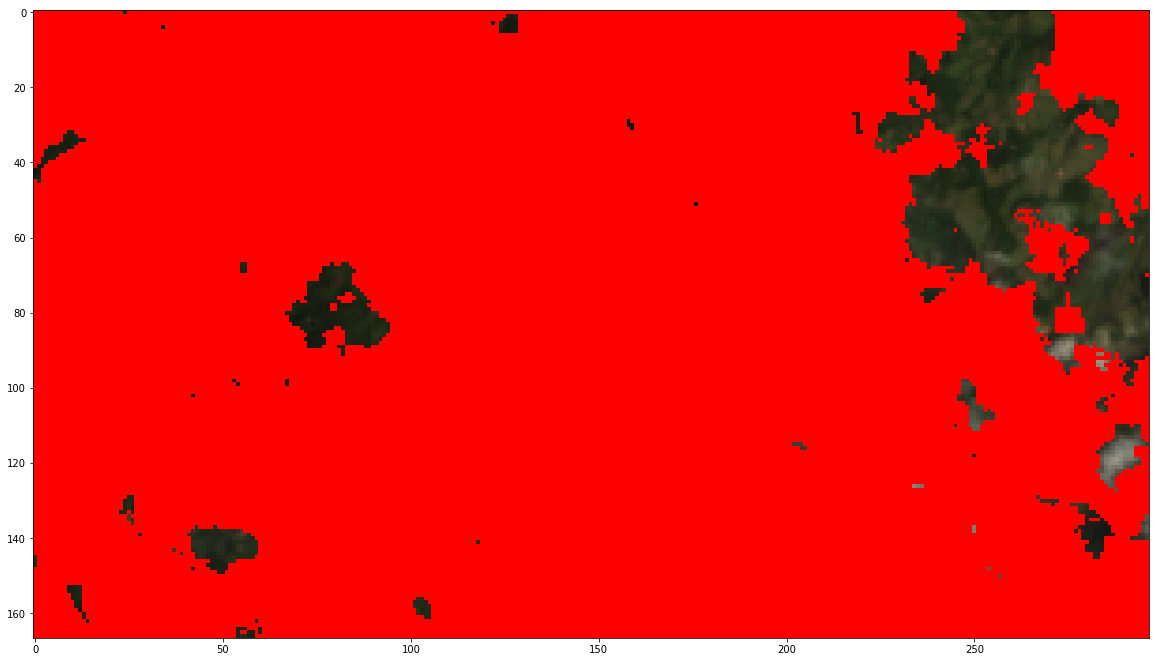

In [65]:
rgb(product_dataset,
    at_index = -1,
    paint_on_mask = [((nan_to_bool(product_dataset.where(inundation_mask).red.values)), (255,0,0))])

>### Inundation Mask + Previous Masks

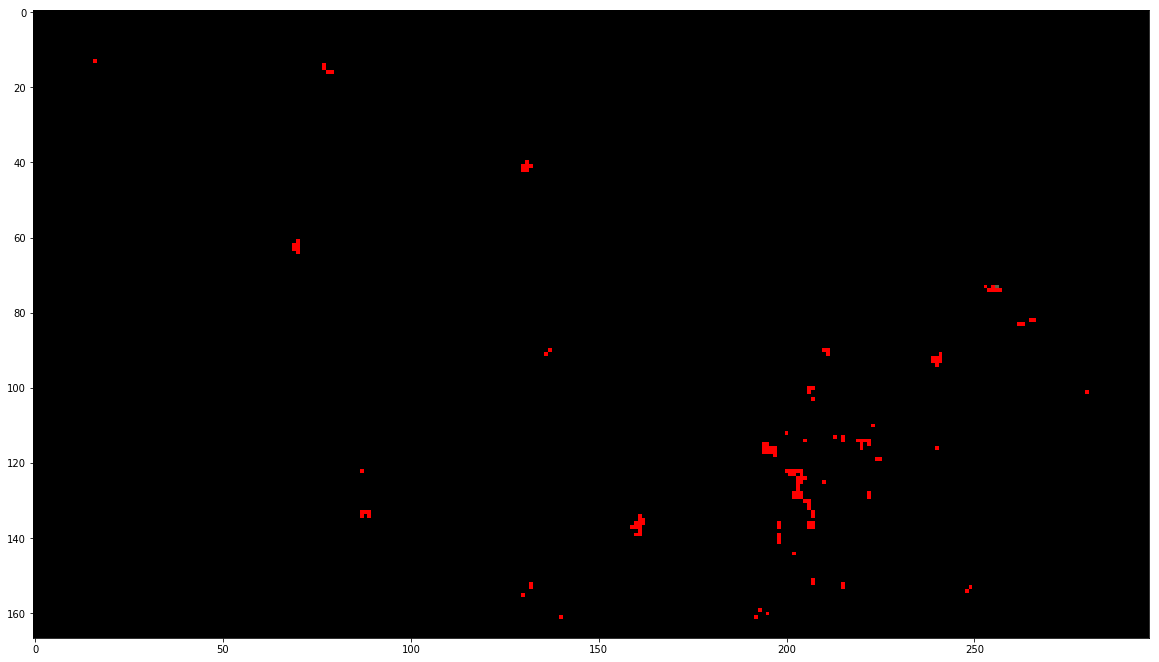

In [66]:
rgb(product_dataset,
    at_index = -1,
    paint_on_mask = [((nan_to_bool(product_dataset.where(inundation_mask).red.values)), (255,0,0)),
                     (np.invert(nan_to_bool(product_dataset.where(height_mask).red.values)), (0,0,0)),
                     (np.invert(nan_to_bool(product_dataset.where(devegetation_mask).red.values)), (0,0,0)),
                     (np.invert(nan_to_bool(product_dataset.cloud_mask.values)), (0,0,0))])

>### Remaining

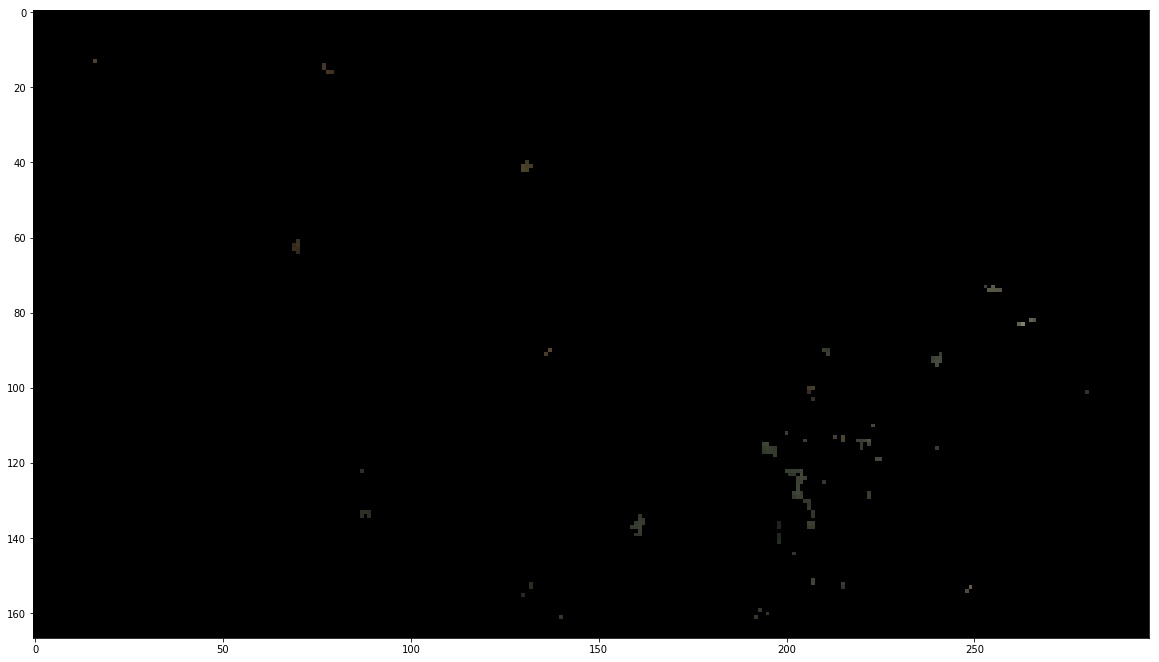

In [67]:
rgb(product_dataset,
    at_index = -1,
    paint_on_mask = [(np.invert(nan_to_bool(product_dataset.where(inundation_mask).red.values)), (0,0,0)),
                     (np.invert(nan_to_bool(product_dataset.where(height_mask).red.values)), (0,0,0)),
                     (np.invert(nan_to_bool(product_dataset.where(devegetation_mask).red.values)), (0,0,0)),
                     (np.invert(nan_to_bool(product_dataset.cloud_mask.values)), (0,0,0))])

# STEP 4: Recurring NDVI change  

In [68]:
non_recurring_ndvi_change = vegetation_sum_threshold(product_dataset, threshold = 1)

In [69]:
product_dataset = xr.merge([product_dataset, non_recurring_ndvi_change])

>### Non-Repeat NDVI Mask

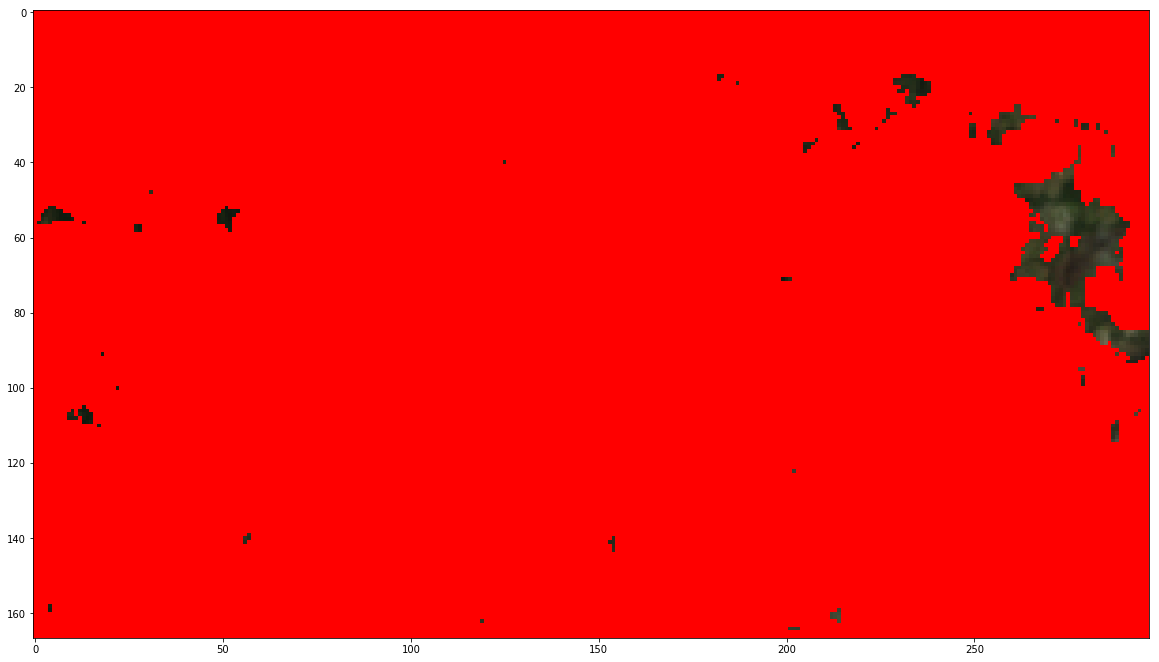

In [70]:
rgb(product_dataset,
    at_index = -1,
    paint_on_mask = [((nan_to_bool(product_dataset.where(non_recurring_ndvi_change).red.values)), (255,0,0))])

>### Non-Repeat NDVI Mask + Previous Masks

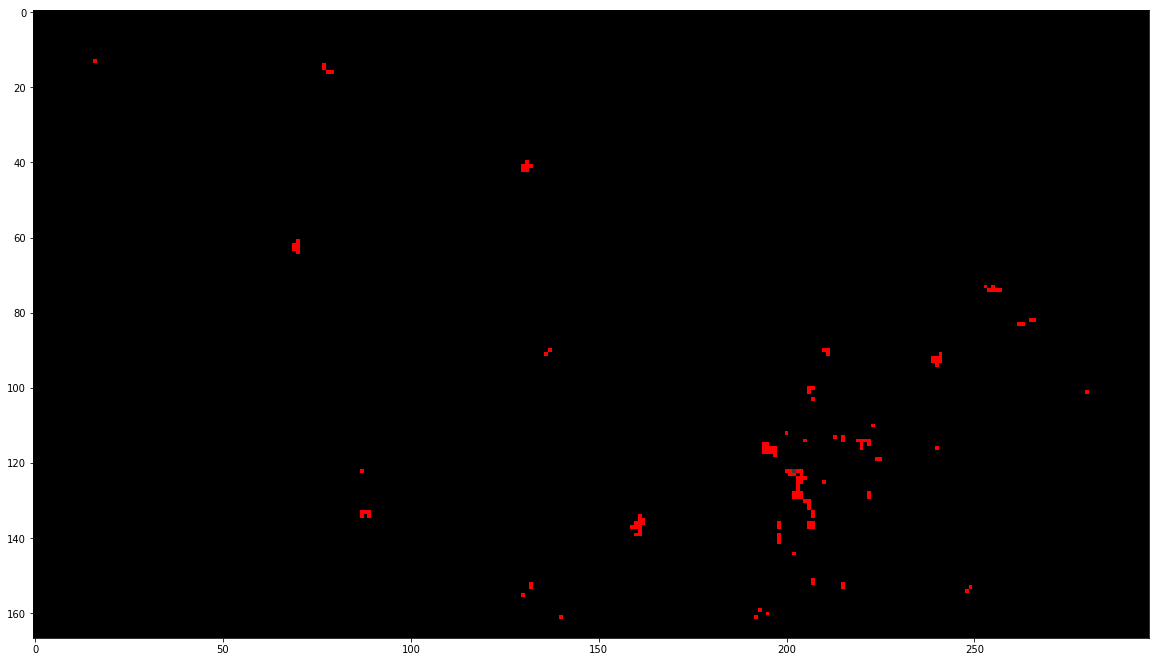

In [71]:
rgb(product_dataset,
    at_index = -1,
    paint_on_mask = [
                    ((nan_to_bool(product_dataset.where(non_recurring_ndvi_change).red.values)),(255,0,0)),
                     (np.invert(nan_to_bool(product_dataset.where(inundation_mask          ).red.values)),(0,0,0)),
                     (np.invert(nan_to_bool(product_dataset.where(height_mask).red.values)), (0,0,0)),
                     (np.invert(nan_to_bool(product_dataset.where(devegetation_mask).red.values)), (0,0,0)),
                     (np.invert(nan_to_bool(product_dataset.cloud_mask.values)), (0,0,0))])

>### Remaining

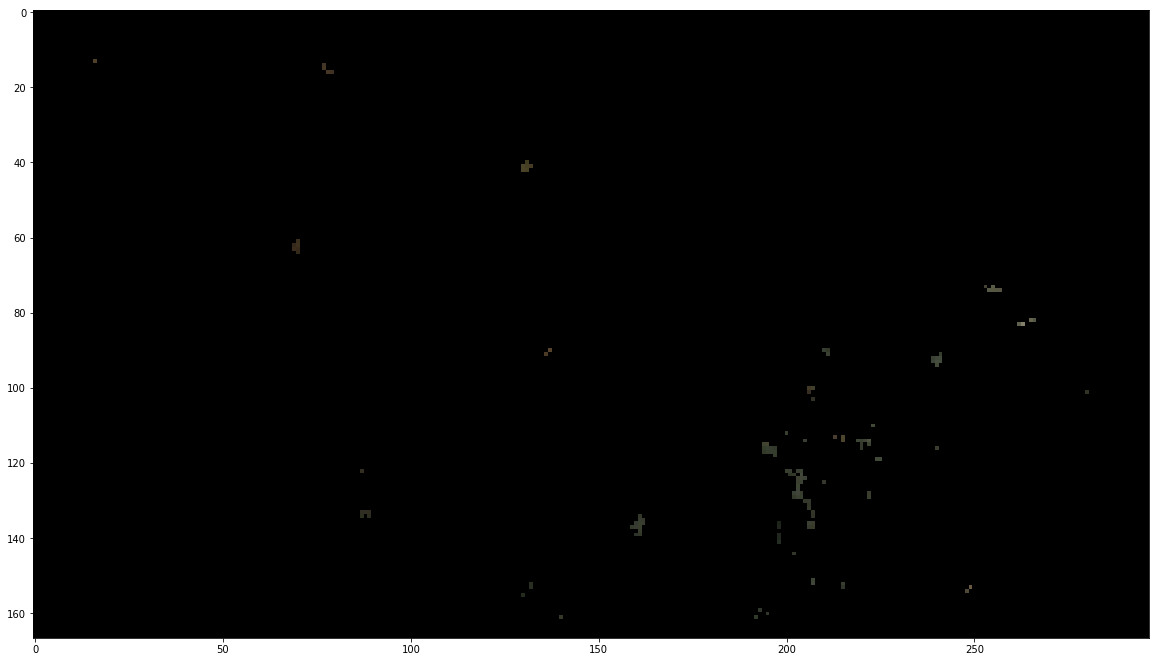

In [72]:
rgb(product_dataset,
    at_index = -1,
    paint_on_mask = [(np.invert(nan_to_bool(product_dataset.where(non_recurring_ndvi_change).red.values)),(0,0,0)),
                     (np.invert(nan_to_bool(product_dataset.where(inundation_mask).red.values)), (0,0,0)),
                     (np.invert(nan_to_bool(product_dataset.where(height_mask).red.values)), (0,0,0)),
                     (np.invert(nan_to_bool(product_dataset.where(devegetation_mask).red.values)), (0,0,0)),
                     (np.invert(nan_to_bool(product_dataset.cloud_mask.values)), (0,0,0))])

# STEP 5: Filter in favor of sufficiently large pixel groups 

In [73]:
remaining_pixel_mask = product_dataset.isel(time = -1).cloud_mask & product_dataset.devegetation_mask & product_dataset.height_mask & product_dataset.inundation_mask & product_dataset.repeat_devegetation_mask

In [74]:
deforestation_mask = boolean_xarray_segmentation_filter(remaining_pixel_mask).rename("deforestation_mask").drop("time")

In [76]:
product_dataset = xr.merge([product_dataset, deforestation_mask])

>### Deforestation Mask  

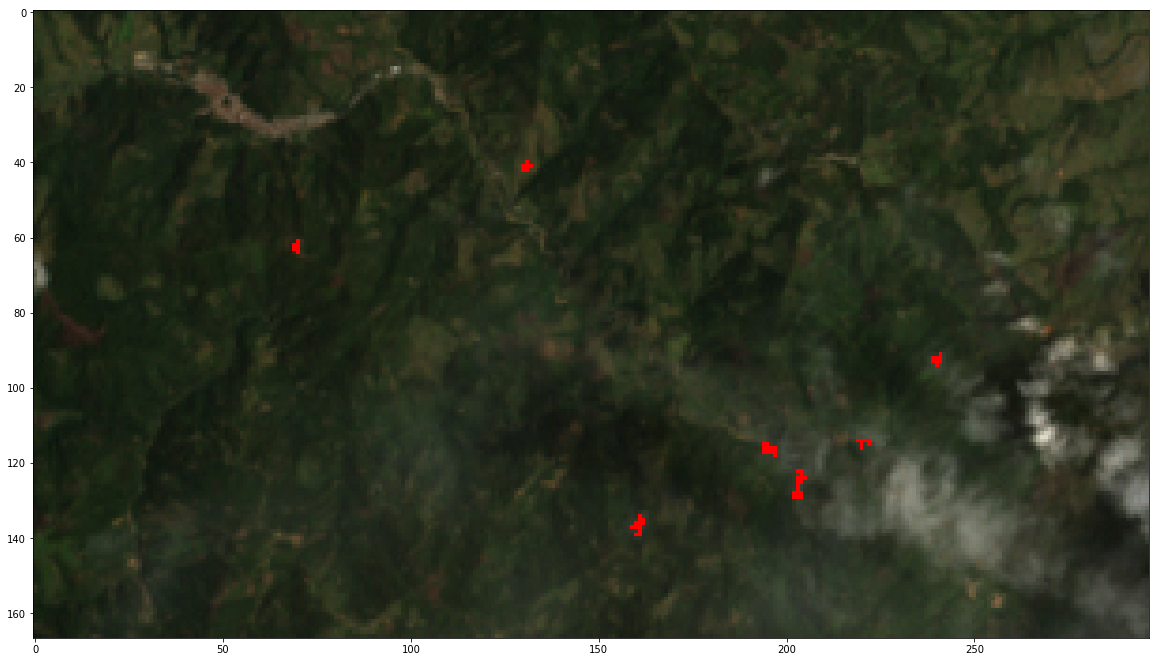

In [77]:
rgb(product_dataset,
    at_index = -1,
    paint_on_mask = [((nan_to_bool(product_dataset.where(deforestation_mask).red.values)), (255,0,0))])

> ### Deforestation Mask in the context of previous filter results  

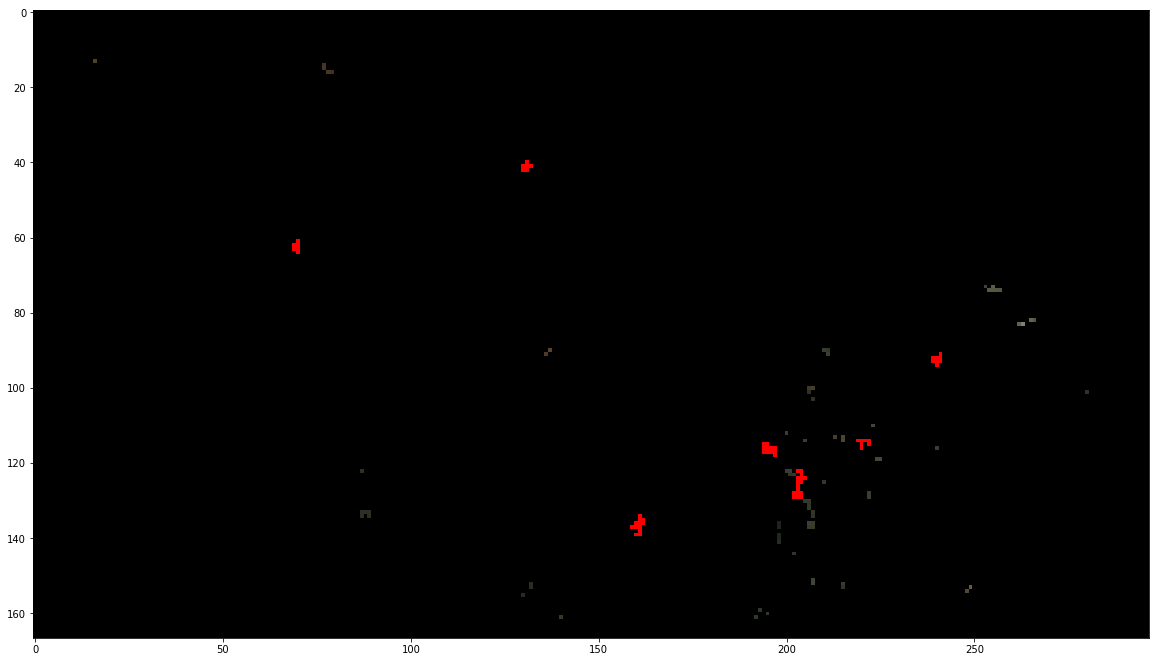

In [78]:
rgb(product_dataset,
    at_index = -1,
    paint_on_mask = [
                     ((nan_to_bool(product_dataset.where(deforestation_mask).red.values)),(255,0,0)),
                     (np.invert(nan_to_bool(product_dataset.where(non_recurring_ndvi_change).red.values)),(0,0,0)),
                     (np.invert(nan_to_bool(product_dataset.where(inundation_mask          ).red.values)),(0,0,0)),
                     (np.invert(nan_to_bool(product_dataset.where(height_mask).red.values)), (0,0,0)),
                     (np.invert(nan_to_bool(product_dataset.where(devegetation_mask).red.values)), (0,0,0)),
                     (np.invert(nan_to_bool(product_dataset.cloud_mask.values)), (0,0,0))])

>### Deforestation After Filtering 

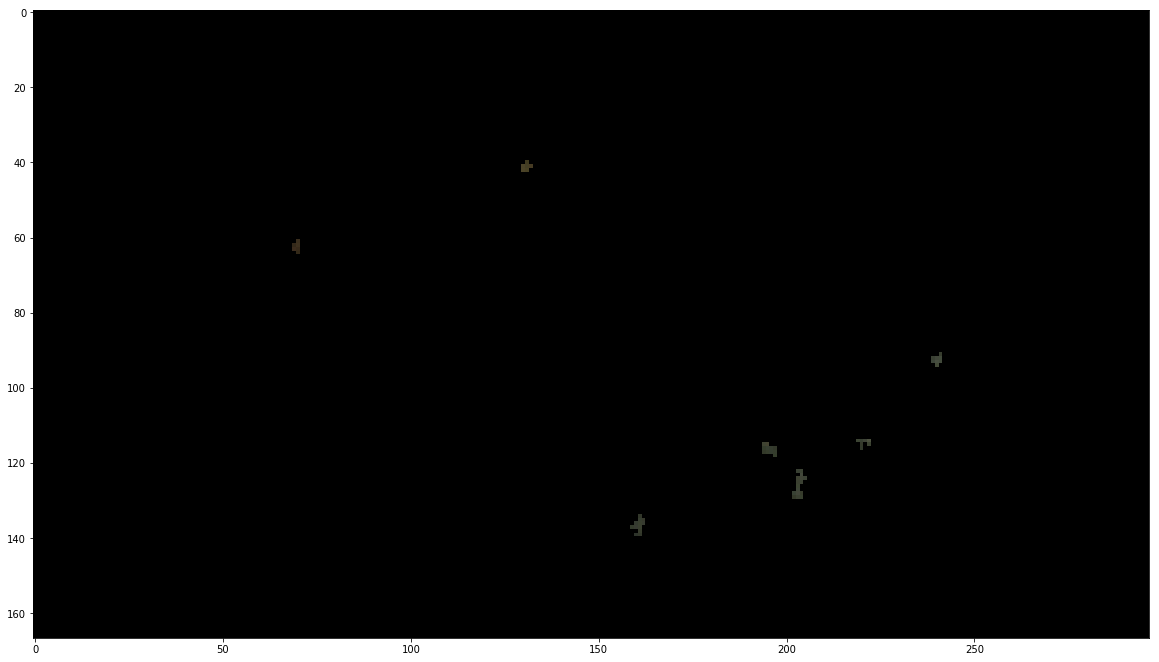

In [79]:
rgb(product_dataset,
    at_index = -1,
    paint_on_mask = [
                     (np.invert(nan_to_bool(product_dataset.where(deforestation_mask).red.values)),(0,0,0)),
                     (np.invert(nan_to_bool(product_dataset.where(non_recurring_ndvi_change).red.values)),(0,0,0)),
                     (np.invert(nan_to_bool(product_dataset.where(inundation_mask          ).red.values)),(0,0,0)),
                     (np.invert(nan_to_bool(product_dataset.where(height_mask).red.values)), (0,0,0)),
                     (np.invert(nan_to_bool(product_dataset.where(devegetation_mask).red.values)), (0,0,0)),
                     (np.invert(nan_to_bool(product_dataset.cloud_mask.values)), (0,0,0))])

In [80]:
display_map(latitude = latitude, longitude = longitude)